<font color='red'>Voor het maken van dit notebook is <i>Keras</i> gebruikt. Hierbij hebben we expliciet de Keras module gebruikt, niet de tensorflow-keras modules. Om deze te installeren kun je  `pip install keras` uitvoeren.</font>

In [1]:
# Import Modules
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Autoencoders
<img src='https://miro.medium.com/max/1574/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png'>

## Wat is een autoencoder?
Een autoencoder is een vorm van Dimensionality Reduction. Hiervan hebben we een eerder voorbeeld gezien (PCA). Een autoencoder is een vorm van een neuraal netwerk, waarbij getraind wordt op de input van het netwerk. Het doel van een autoencoder is om de output zo gelijk mogelijk te houden aan de input, waarbij er een $n$ aantal neuronen in de "bottleneck" layer zitten die kleiner zijn dan het aantal neuronen in de inputlayer. Op deze manier kan, na het trainen van het netwerk, het aantal dimensies van de data worden verkleind.<br><br>

Een autoencoder kan verdeeld worden in 3 onderdelen:
- Encoder
- Bottleneck layer
- Decoder

De Encoder zorgt voor het verkleinen van het aantal ingevoerde dimensies, de bottleneck layer bevat de hoeveelheid dimensies waar de gebruiker naartoe wil werken, de Decoder vergroot het aantal dimensies weer naar de hoeveelheid van de inputlayer, zodat de loss van input/output berekend kan worden. De encoder en decoder hoeven niet te bestaan uit 1 layer, deze kunnen opgebouwd worden uit verschillende layers. Hier wordt vaak gebruik gemaakt van het 'sandwich' model.<br><br>

Om duidelijk te zien hoe een autoencoder werkt, zullen we deze techniek toepassen bij het trainen van een $k$-nearest neighbors model op de MNIST dataset.

# kNN op de MNIST Dataset

Om een autoencoder te gebruiken moeten we eerst een baseline opstellen, dit doen we door een $k$-nearest neighbors model op te zetten met scikit-learn, en deze te trainen met de MNIST dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train[:3])
print(y_train[:3])

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[5 0 4]


De geïmporteerde MNIST data bevat een array met 2-dimensionale arrays van 28x28 elementen. Elk van deze punten bestaat uit een RGB waarde (0-255). Om makkelijk met de data te kunnen werken moeten we de RGB waarden normaliseren naar waarden tussen 0 en 1. 

In [3]:
x_train = x_train.astype(float)
x_train /= 255

x_test = x_test.astype(float)
x_test /= 255

Voor het trainen van het model is het handig om de data om te zetten naar 1x784 arrays, in plaats van 2-dimensionale 28x28 arrays.

In [4]:
def reshape(data, rows):
    return np.asarray([[k for j in i for k in j] for i in data[:rows]])

x_train = reshape(x_train, 6000)
x_test = reshape(x_test, 1000)
y_train = y_train[:6000]
y_test = y_test[:1000]

print(x_train.shape)
print(x_test.shape)

(6000, 784)
(1000, 784)


Met de genormaliseerde data kunnen we een baseline opstellen met $k$-nearest neighbors. Om dit model op te stellen en te trainen kunnen we gebruikmaken van <i>scikit-learn</i>. Gebruik voor het berekenen van de score de <i>.score()</i> functie van het model. TIP: maak bij het berekenen van de score gebruik van 1000 elementen uit <i>x_test</i>. Het berekenen van de score kost erg veel tijd wanneer dit over alle testdata berekend moet worden.

In [5]:
#TODO: Maak een kNN algoritme
n_neighbours = 5

knn = KNeighborsClassifier(n_neighbours)
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.916

# Bouwen van een Autoencoder
Voor het trainen van de $k$-nearest neighbors gebruiken we op dit moment alle 784 dimensies/pixels van alle afbeeldingen. Je zult al gemerkt hebben dat het berekenen van de score wat tijd in beslag neemt. Om dit omlaag te brengen kunnen we ervoor kiezen om minder dimensies/pixels te gebruiken. Om dit te bepalen kunnen we een autoencoder gebruiken<br><br>

Omdat een autoencoder een vorm van een neuraal netwerk is, kunnen we <i>Keras</i> gebruiken om een model op te zetten en te trainen.<br><br>

Onderstaande functie <i>display_digits()</i> is voor het uitprinten van de afbeeldingen zodat we het resultaat kunnen vergelijken van de originele afbeeldingen en de afbeeldingen wanneer ze door de autoencoder zijn gehaald.

In [6]:
def display_digits(x_test, x_decoded, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Voor het bouwen van een neuraal netwerk kan de <i>Sequential([])</i> module van Keras worden gebruikt. Hierin dienen een aantal Dense layers te worden aangemaakt, zodat het netwerk getraind kan worden. We zullen de meest eenvoudige autoencoder opzetten, met een input layer, bottleneck layer, en een output layer. Voor de activatiefuncties kan 'relu' worden gebruikt in de bottleneck layer, en 'sigmoid' in de output layer.<br><br>

In [8]:
encoding_dim = 32 #op deze manier reduceren we de dimensies bij een factor van 24.5 (784/24.5=32)

#TODO: aanmaken van autoencoder model door middel van Sequential en Dense layers
autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, input_shape=(x_train.shape[1],), activation='relu'))
autoencoder.add(Dense(x_train.shape[1], activation='sigmoid'))
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Om de autoencoder te trainen dient het model gecompileerd te worden met <i>compile()</i>. Voor de optimizer kan voor 'adadelta' gekozen worden. Omdat we gebruikmaken van data tussen 0 en 1 gebruiken we 'binary_crossentropy' als loss-functie. Wanneer je data hebt dat niet tussen 0 en 1 ligt, kun je gebruikmaken van Mean Squared Error.

In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 6000 samples, validate on 1000 samples
Epoch 1/50
6000/6000 [==============================] - 1s 149us/step - loss: 0.6802 - val_loss: 0.6493
Epoch 2/50
6000/6000 [==============================] - 1s 93us/step - loss: 0.5521 - val_loss: 0.4221
Epoch 3/50
6000/6000 [==============================] - 1s 95us/step - loss: 0.3485 - val_loss: 0.3090
Epoch 4/50
6000/6000 [==============================] - 1s 94us/step - loss: 0.2965 - val_loss: 0.2880
Epoch 5/50
6000/6000 [==============================] - 1s 98us/step - loss: 0.2849 - val_loss: 0.2804
Epoch 6/50
6000/6000 [==============================] - 1s 89us/step - loss: 0.2800 - val_loss: 0.2764
Epoch 7/50
6000/6000 [==============================] - 1s 95us/step - loss: 0.2770 - val_loss: 0.2731
Epoch 8/50
6000/6000 [==============================] - 1s 91us/step - loss: 0.2749 - val_loss: 0.2711
Epoch 9/50
6000/6000 [==============================] - 1s 85us/step - loss: 0.2731 - val_loss: 0.2694
Epoch 10/50
6000/6000 [=

Om te testen of de autoencoder dichtbij de de originele input zit, kan gebruik worden gemaakt van de <i>.predict()</i> functie van de autoencoder. Als deze functie gebruikt wordt om x_test te voorspellen, kan deze data samen met x_test zelf in de hierboven gedefinieerde <i>display_digits()</i> worden gebruikt om een aantal (10) originele x_test en voorspelde x_test afbeeldingen te printen.

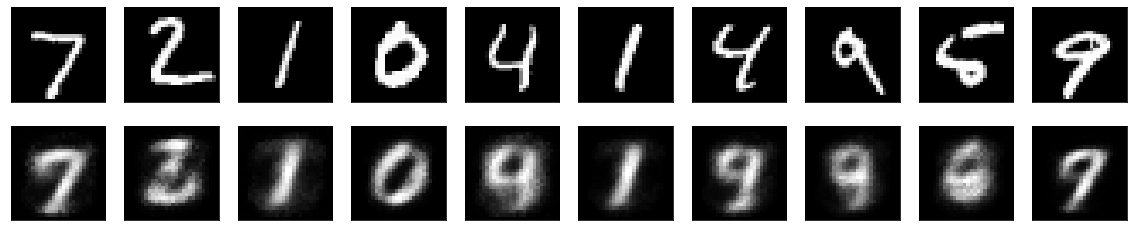

In [14]:
x_decoded = autoencoder.predict(x_test)
display_digits(x_test, x_decoded)

Als de voorspelde afbeeldingen van de autoencoder lijken op de originele afbeeldingen, kunnen we het decoder gedeelte van de autoencoder weglaten, deze is alleen bedoeld voor het trainen. Voor het daadwerkelijk reduceren van de data hebben we alleen de encoder nodig. Omdat onze autoencoder maar 1 layer heeft als encoder, kunnen we layer[0] gebruiken uit ons autoencoder object

In [17]:
#TODO: maak een encoder Sequential([]) model door de eerste layer te nemen uit het autoencoder model
model = Sequential()
model.add(autoencoder.layers[0])

# kNN Met gereduceerde dimensies
Omdat we nu een getrainde encoder hebben, kunnen we deze gebruiken om de dimensies van x_train, x_test te reduceren, zodat we de gereduceerde data te gebruiken om een $k$-nearest neighbors te trainen. Gebruik hier weer hetzelfde aantal neighbors en bereken de score van het model ook weer met 1000 waarden uit de testdata.

In [18]:
#TODO: predict x_train_encoded en x_test_encoded met behulp van de encoder
x_train_encoded = model.predict(x_train)
x_test_encoded = model.predict(x_test)

In [22]:
#TODO: train een kNN met x_train_encoded en x_test_encoded met hetzelfde aantal neighbors als in de baseline
n_neighbours = 5
knn = KNeighborsClassifier(n_neighbours)
knn.fit(x_train_encoded, y_train)
knn.score(x_test_encoded, y_test)

0.859

# Opdracht: Deep Autoencoder
Probeer met deze tools een nieuwe autoencoder te maken, door gebruik te maken van meerdere layers in het encoder en decoder gedeelte. Dit wordt een Deep Autoencoder genoemd. Test de werking van je autoencoder door met behulp van een encoder de data weer in een $k$-nearest neighbors te stoppen. Denk bij het maken van meerdere layers aan het 'sandwich' model.

In [23]:
encoding_dim = 32

autoencoder.add(Dense(4 * encoding_dim, input_shape=(x_train.shape[1],), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(x_train.shape[1], activation='sigmoid'))

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [24]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 6000 samples, validate on 1000 samples
Epoch 1/50
6000/6000 [==============================] - 1s 168us/step - loss: 0.6887 - val_loss: 0.6788
Epoch 2/50
6000/6000 [==============================] - 1s 108us/step - loss: 0.4991 - val_loss: 0.2666
Epoch 3/50
6000/6000 [==============================] - 1s 106us/step - loss: 0.2674 - val_loss: 0.2582
Epoch 4/50
6000/6000 [==============================] - 1s 114us/step - loss: 0.2635 - val_loss: 0.2564
Epoch 5/50
6000/6000 [==============================] - 1s 149us/step - loss: 0.2617 - val_loss: 0.2560
Epoch 6/50
6000/6000 [==============================] - 1s 114us/step - loss: 0.2600 - val_loss: 0.2538
Epoch 7/50
6000/6000 [==============================] - 1s 103us/step - loss: 0.2588 - val_loss: 0.2516
Epoch 8/50
6000/6000 [==============================] - 1s 105us/step - loss: 0.2580 - val_loss: 0.2525
Epoch 9/50
6000/6000 [==============================] - 1s 99us/step - loss: 0.2572 - val_loss: 0.2519
Epoch 10/50
6000/

In [25]:
x_train_encoded = autoencoder.predict(x_train)
x_test_encoded = autoencoder.predict(x_test)

n_neighbours = 5
knn = KNeighborsClassifier(n_neighbours)
knn.fit(x_train_encoded, y_train)
knn.score(x_test_encoded, y_test)

0.712

### Bronnen
https://blog.keras.io/building-autoencoders-in-keras.html<br>
https://keras.io/models/sequential/<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html<br>
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798<br>
https://www.youtube.com/watch?v=H1AllrJ-_30<br>
https://www.researchgate.net/post/Should_the_output_function_for_outer_layer_and_activation_function_of_hidden_layer_in_auto_encoder_be_same<br>